In [61]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# ML model imports
from sklearn.linear_model import LogisticRegression # Logistic regression
from sklearn.naive_bayes import MultinomialNB # NAIVE BAYES
from sklearn.ensemble import RandomForestClassifier # Random forests

# Standard evaluation and splitting tools
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Text processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [62]:
# using file already cleaned as in https://colab.research.google.com/drive/1iEhkDRmuocCsitAOdyq1JoH6vGzwIGFQ?usp=sharing
data = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/hw3/ecommerce-reviews-full-set.csv')
data.head()

,Age,Recommended_IND,Division_Name,Department_Name,Class_Name,Title_Review
0,33,1,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...
1,34,1,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...
2,60,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
3,50,1,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
4,47,1,General,Tops,Blouses,Flattering shirt This shirt is very flattering...


Use the Review Text and any other features to predict whether someone will recommend (Recommended IND) a product or not.

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22629 entries, 0 to 22628
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              22629 non-null  int64 
 1   Recommended_IND  22629 non-null  int64 
 2   Division_Name    22629 non-null  object
 3   Department_Name  22629 non-null  object
 4   Class_Name       22629 non-null  object
 5   Title_Review     22629 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.0+ MB


# Preprocessing and cleanup

In [64]:
#cleanup was done as shown above
data.isna().sum()

Age                0
Recommended_IND    0
Division_Name      0
Department_Name    0
Class_Name         0
Title_Review       0
dtype: int64

In [65]:
#all cleaned except 2966 rows with missing title
data.shape

(22629, 6)

In [66]:
categorical_columns=['Division_Name','Department_Name','Class_Name']
#data[categorical_columns].value_counts()

In [67]:
numerical_columns=['Age']

In [68]:
stopwordSet = set(stopwords.words("english"))
lemma = WordNetLemmatizer()

In [69]:
def cleanup_sentances(sentence):    
    text = re.sub('[^a-zA-Z]'," ", sentence) # Removing non a-z characters
    #print(sentence) # Print out non-cleaned text
    text = text.lower() # Lowering all text
    text = word_tokenize(text, language="english") # Splitting each word into an element of a list
    text = [lemma.lemmatize(word) for word in text if(word) not in stopwordSet] # Lemmatizing words and removing stopwords
    text = " ".join(text) # Putting words back into a single string. ['the', 'brown', 'cow'] --> 'the brown cow'
    #print(text, '\n') # Print out cleaned text
    return text

In [70]:
# apply function 
data['cleaned_text'] = data['Title_Review'].apply(cleanup_sentances)
data.head()

,Age,Recommended_IND,Division_Name,Department_Name,Class_Name,Title_Review,cleaned_text
0,33,1,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...,absolutely wonderful silky sexy comfortable
1,34,1,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...,love dress sooo pretty happened find store gla...
2,60,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,major design flaw high hope dress really wante...
3,50,1,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...",favorite buy love love love jumpsuit fun flirt...
4,47,1,General,Tops,Blouses,Flattering shirt This shirt is very flattering...,flattering shirt shirt flattering due adjustab...


In [71]:
## Create count vector for cleaned review text
# looks to do better AUC if matrix is bigger but if too big then runs out of memory
cv = CountVectorizer(max_features = 2500)
cv_matrix = cv.fit_transform(data.cleaned_text).toarray()
cv_matrix = pd.DataFrame(cv_matrix, columns=cv.get_feature_names())
cv_matrix.head()

,aa,able,absolute,absolutely,abt,accent,accentuate,accentuated,accentuates,acceptable,accessorize,accessory,accidentally,accommodate,according,accurate,accurately,achieve,across,acrylic,actual,actually,add,added,adding,addition,additional,additionally,adjust,adjustable,adjusted,adjusting,admit,adn,adorable,adore,advertised,advice,aesthetic,affordable,...,worth,worthy,would,woven,wow,wrap,wrapped,wrinkle,wrinkled,wrinkly,wrist,write,writing,written,wrong,wrote,xl,xsmall,xsp,xspetite,xx,xxsp,yarn,yay,year,yellow,yes,yesterday,yet,yikes,yo,yoga,yoke,young,younger,zero,zip,zipped,zipper,zipping
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
# Instead of CV try TF-IDF
#TF (Term frequency) : Reward words having a high occurrence in a document [Frequent]
# IDF (Inverse Document Frequency) : Penalize words appearing many times in a document collection. Frequent words should not have have high weight eg. "or" "not" "is" "the" [Reward Rarity].
# Hence rare words in a document collection but frequent in a particular document get high weight.
# Combining TF and IDF together => assign high weight to discriminative words in a document

tfidf = TfidfVectorizer(max_features = 2500) 
tfidf_matrix = tfidf.fit_transform(data.cleaned_text).toarray() 

In [73]:
tfidf_matrix = pd.DataFrame(tfidf_matrix, columns=tfidf.get_feature_names())
tfidf_matrix.head()

,aa,able,absolute,absolutely,abt,accent,accentuate,accentuated,accentuates,acceptable,accessorize,accessory,accidentally,accommodate,according,accurate,accurately,achieve,across,acrylic,actual,actually,add,added,adding,addition,additional,additionally,adjust,adjustable,adjusted,adjusting,admit,adn,adorable,adore,advertised,advice,aesthetic,affordable,...,worth,worthy,would,woven,wow,wrap,wrapped,wrinkle,wrinkled,wrinkly,wrist,write,writing,written,wrong,wrote,xl,xsmall,xsp,xspetite,xx,xxsp,yarn,yay,year,yellow,yes,yesterday,yet,yikes,yo,yoga,yoke,young,younger,zero,zip,zipped,zipper,zipping
0,0.0,0.0,0.0,0.387174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.194446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151559,0.0,0.132828,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


# Prepare datasets

In [74]:
#dependent 
y=data['Recommended_IND']
y.shape

(22629,)

In [75]:
#create dummies for categorical data
data_subset = data[numerical_columns + categorical_columns]
data_subset = pd.get_dummies(data = data_subset, columns=categorical_columns)
data_subset.head()

,Age,Division_Name_General,Division_Name_General Petite,Division_Name_Initmates,Department_Name_Bottoms,Department_Name_Dresses,Department_Name_Intimate,Department_Name_Jackets,Department_Name_Tops,Department_Name_Trend,Class_Name_Blouses,Class_Name_Casual bottoms,Class_Name_Chemises,Class_Name_Dresses,Class_Name_Fine gauge,Class_Name_Intimates,Class_Name_Jackets,Class_Name_Jeans,Class_Name_Knits,Class_Name_Layering,Class_Name_Legwear,Class_Name_Lounge,Class_Name_Outerwear,Class_Name_Pants,Class_Name_Shorts,Class_Name_Skirts,Class_Name_Sleep,Class_Name_Sweaters,Class_Name_Swim,Class_Name_Trend
0,33,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,34,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,50,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,47,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
cv_matrix.shape

(22629, 2500)

In [77]:
tfidf_matrix.shape

(22629, 2500)

In [78]:
data_subset.shape

(22629, 30)

In [79]:
#need to reset index otherwise concat is off
cv_matrix.reset_index(inplace=True)
tfidf_matrix.reset_index(inplace=True)
data_subset.reset_index(inplace=True)
#concat side by side

# Use CV or TF-IDF
X = pd.concat([cv_matrix, data_subset], axis=1)
#X = pd.concat([tfidf_matrix, data_subset], axis=1)

#index gets duplicated so remove it
del X['index']
X.reset_index(inplace=True)
X.shape

(22629, 2531)

In [80]:
X.head()

,index,aa,able,absolute,absolutely,abt,accent,accentuate,accentuated,accentuates,acceptable,accessorize,accessory,accidentally,accommodate,according,accurate,accurately,achieve,across,acrylic,actual,actually,add,added,adding,addition,additional,additionally,adjust,adjustable,adjusted,adjusting,admit,adn,adorable,adore,advertised,advice,aesthetic,...,yo,yoga,yoke,young,younger,zero,zip,zipped,zipper,zipping,Age,Division_Name_General,Division_Name_General Petite,Division_Name_Initmates,Department_Name_Bottoms,Department_Name_Dresses,Department_Name_Intimate,Department_Name_Jackets,Department_Name_Tops,Department_Name_Trend,Class_Name_Blouses,Class_Name_Casual bottoms,Class_Name_Chemises,Class_Name_Dresses,Class_Name_Fine gauge,Class_Name_Intimates,Class_Name_Jackets,Class_Name_Jeans,Class_Name_Knits,Class_Name_Layering,Class_Name_Legwear,Class_Name_Lounge,Class_Name_Outerwear,Class_Name_Pants,Class_Name_Shorts,Class_Name_Skirts,Class_Name_Sleep,Class_Name_Sweaters,Class_Name_Swim,Class_Name_Trend
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,33,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,34,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,60,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,50,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,47,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
## Split the dataset into Training Validation and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train , test_size=0.2, random_state = 0)

# Common functions

In [82]:
def create_roc_plot(name, predictions):
  auc = roc_auc_score(y_valid, predictions).round(2)
  fpr, tpr, _ = roc_curve(y_valid, predictions)

  print('AUC:'+name, auc)
  print(classification_report(y_valid, predictions.round(0)))
  print(confusion_matrix(y_valid, predictions.round(0)))

  plt.figure(figsize=(5, 3))
  plt.plot([0, 1], [0, 1], linestyle='--')  # plot horizontal line 
  plt.plot(fpr, tpr, label='{} AUC = {}'.format(name, auc)) # plot the roc curve for the model
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(loc='lower right')  # show the legend
  plt.show() # show the plot
  return None

# Logistic regression

In [83]:
model_lr = LogisticRegression(max_iter=400)
model_lr.fit(X_train, y_train)
Y_pred_lr = model_lr.predict_proba(X_valid)[:, 1]

AUC:Logistic Regression 0.93
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       653
           1       0.93      0.95      0.94      2968

    accuracy                           0.90      3621
   macro avg       0.84      0.81      0.82      3621
weighted avg       0.90      0.90      0.90      3621

[[ 436  217]
 [ 150 2818]]


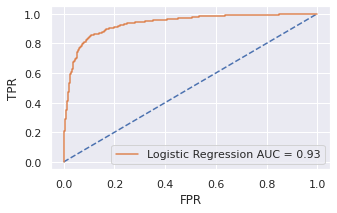

In [84]:
create_roc_plot("Logistic Regression", Y_pred_lr)

# Naive Bayes

In [85]:
## Naives bayes multinomial
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
Y_pred_nb = model_nb.predict_proba(X_valid)[:, 1]

AUC:Naive Bayes 0.94
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       653
           1       0.96      0.91      0.93      2968

    accuracy                           0.89      3621
   macro avg       0.81      0.86      0.83      3621
weighted avg       0.90      0.89      0.90      3621

[[ 534  119]
 [ 272 2696]]


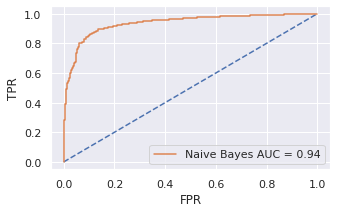

In [86]:
create_roc_plot("Naive Bayes", Y_pred_nb)

# XGBoost

In [87]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
Y_pred_xgb =  model_xgb.predict_proba(X_valid)[:, 1]

AUC:XGB 0.91
              precision    recall  f1-score   support

           0       0.81      0.32      0.46       653
           1       0.87      0.98      0.92      2968

    accuracy                           0.86      3621
   macro avg       0.84      0.65      0.69      3621
weighted avg       0.86      0.86      0.84      3621

[[ 211  442]
 [  50 2918]]


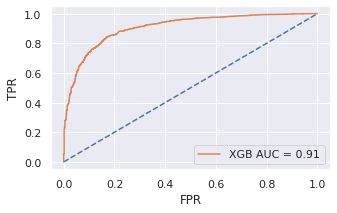

In [88]:
create_roc_plot("XGB", Y_pred_xgb)

# Test

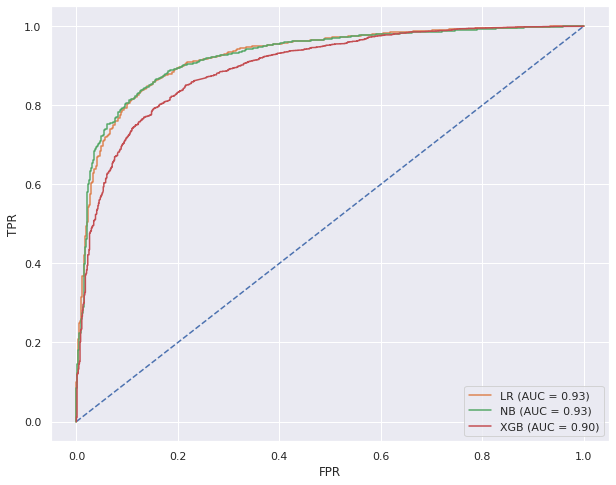

In [89]:
#use test data
pred_lr_test = model_lr.predict_proba(X_test)[:, 1]
pred_nb_test = model_nb.predict_proba(X_test)[:,1]
pred_xgb_test =  model_xgb.predict_proba(X_test)[:, 1]

# calculate scores
auc_lr_test = roc_auc_score(y_test, pred_lr_test)
auc_nb_test = roc_auc_score(y_test, pred_nb_test)
auc_xgb_test = roc_auc_score(y_test, pred_xgb_test)

# calculate roc curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, pred_lr_test)
fpr_nb, tpr_nb, _ = roc_curve(y_test, pred_nb_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, pred_xgb_test)

plt.figure(figsize=(10, 8))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_lr, tpr_lr, label='LR (AUC = %0.2f)' % auc_lr_test)
plt.plot(fpr_nb, tpr_nb, label='NB (AUC = %0.2f)' % auc_nb_test)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (AUC = %0.2f)' % auc_xgb_test)

# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()